# Siamese Network Architecture using MNIST Dataset

If you recall Chapter 2: Metrics Based Methods, in book, Siamese Networks looks something like this:

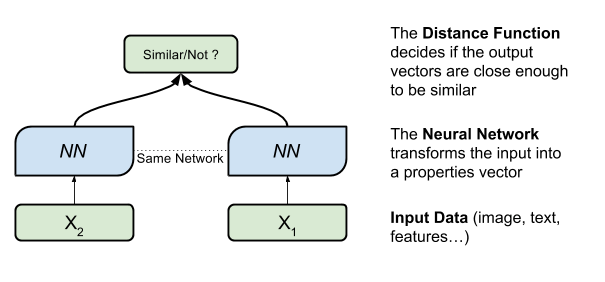


In this tutorial, we will build a Siamese Network Architecture for One-Shot Learning using Pytorch and other python libraries. 
we will building modules step by step:

1. Data Preprocessing: Creating Pairs.

2. Create a Siamese Network Architecture.

3. Train it using Small MNIST dataset. 

4. Visualize Embeddings.

##### Step1: Lets first import all libraries needed.

In [16]:
# -*- encoding: utf-8 -*-
import argparse
import torch
import torchvision.datasets as dsets
import random
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torchvision import transforms
import pickle
import torch
import torch.nn as nn

### Data Preprocessing
As we learned in theory part of Siamese Network, that as part of data preprocessing we need to create pairs.
1. 1 pair-> similar; y=0
2. 1 pair-> dissimilar; y=1

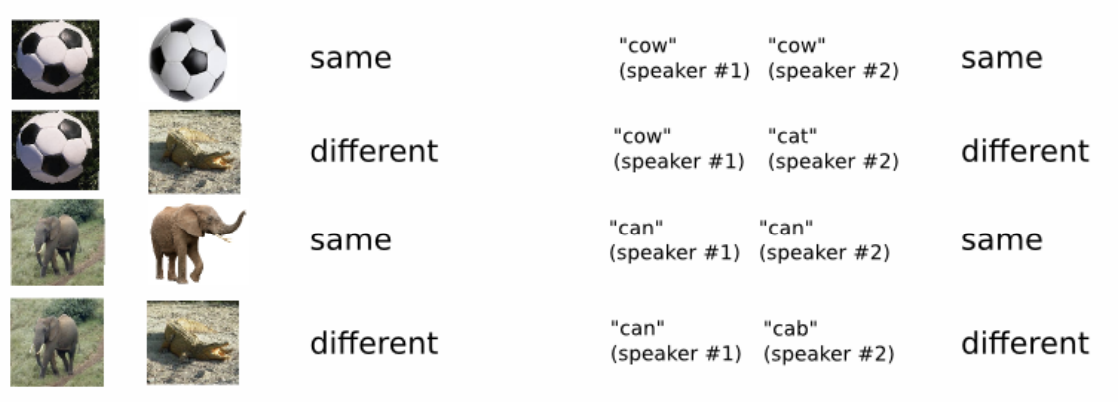

Note: We are using contrastive loss function.

#### Step2: To preporcess data, and create iterator for model, first create a Dataset Loader Class.

In [17]:
class Dataset(object):
    '''
    Class Dataset:
    Input: numpy values
    Output: torch variables.
    '''
    def __init__(self, x0, x1, label):
        self.size = label.shape[0] 
        self.x0 = torch.from_numpy(x0)
        self.x1 = torch.from_numpy(x1)
        self.label = torch.from_numpy(label)

    def __getitem__(self, index):
        return (self.x0[index],
                self.x1[index],
                self.label[index])

    def __len__(self):
        return self.size

##### Before creating an iterator, lets create pairs, and preprocess images in them.

In [18]:
def create_pairs(data, digit_indices):
    x0_data = []
    x1_data = []
    label = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    for d in range(10): # for MNIST dataset: as we have 10 digits
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            x0_data.append(data[z1] / 255.) # Image Preprocessing Step
            x1_data.append(data[z2] / 255.) # Image Preprocessing Step
            label.append(1)
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            x0_data.append(data[z1] / 255.) # Image Preprocessing Step
            x1_data.append(data[z2] / 255.) # Image Preprocessing Step
            label.append(0)

    x0_data = np.array(x0_data, dtype=np.float32)
    x0_data = x0_data.reshape([-1, 1, 28, 28])
    x1_data = np.array(x1_data, dtype=np.float32)
    x1_data = x1_data.reshape([-1, 1, 28, 28])
    label = np.array(label, dtype=np.int32)
    return x0_data, x1_data, label

###### create iterator: returns set of given batchsize for training purpose

In [19]:
def create_iterator(data, label, batchsize, shuffle=False):
    digit_indices = [np.where(label == i)[0] for i in range(10)]
    x0, x1, label = create_pairs(data, digit_indices)
    ret = Dataset(x0, x1, label)
    return ret

# Loss Function: Contrastive Loss Function 

#### Step 3: Create Loss Function
As we know contrastive loss function consists of 2 parts:
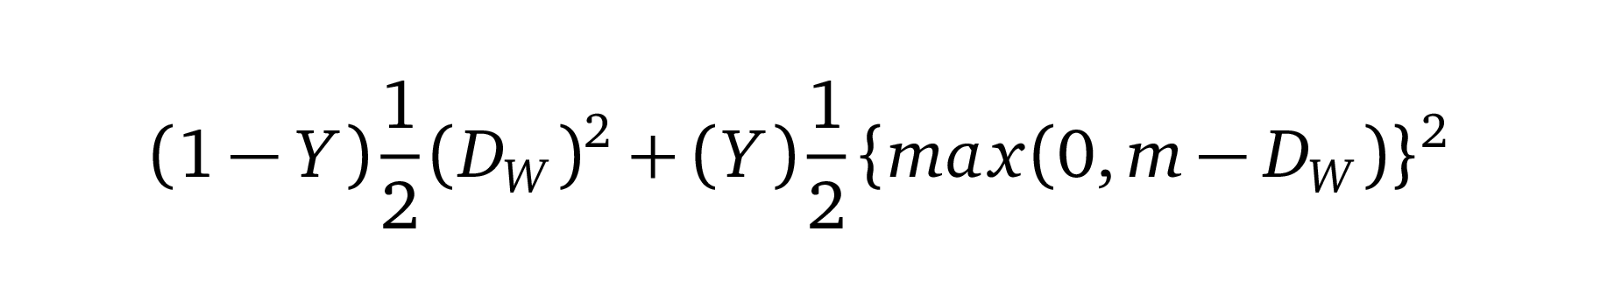

1. for similar points: (1-y)*(distance_function)^2
2. for dissimilar points: y*{max(0,(m-distance_function^2)}

Here Distance Function is taken as euclidean distance, also known as root mean square.

In [20]:
def contrastive_loss_function(x0, x1, y, margin=1.0):
    # euclidean distance
    diff = x0 - x1
    dist_sq = torch.sum(torch.pow(diff, 2), 1)
    dist = torch.sqrt(dist_sq)
    mdist = margin - dist
    dist = torch.clamp(mdist, min=0.0)
    loss = y * dist_sq + (1 - y) * torch.pow(dist, 2)
    loss = torch.sum(loss) / 2.0 / x0.size()[0]
    return loss

# Siamese Network Architecture

##### Step 4: Creating Siamese Network Architecture
For this first lets create a class called SiameseNetwork with 2 functions:
###### 1. forward_once: In forward_once pass through all layers and returns the output embeddings 
###### 2. forward: In forward, call forward_once 2 times for the Input pair given, and returns the embeddings obtained


As discussed in theory part of Siamese Network, we share parameters of twins, so we don't need to create explicitly both brances, we can just create one.

In [21]:
class SiameseNetwork(nn.Module):
    def __init__(self,flag_kaf=False):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(20, 50, kernel_size=5),
            nn.MaxPool2d(2, stride=2))
        self.fc1 = nn.Sequential(
            nn.Linear(50 * 4 * 4, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500,10),
            nn.Linear(10, 2))
        
    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


#### Reduce MNIST dataset, choose random '2000' points
Setting Batch-Size=128, and importing MNIST dataset

You can download MNIST dataset from link

*** feel free to modify these parameters and experiment with them !!! ***

In [22]:
batchsize=128
train = dsets.MNIST(root='../data/',train=True,download=True)
test = dsets.MNIST(root='../data/',train=False,transform=transforms.Compose([transforms.ToTensor(),]))
indices= np.random.choice(len(train.train_labels.numpy()), 2000, replace=False)
indices_test= np.random.choice(len(test.test_labels.numpy()), 100, replace=False)

##### We created an iterator above, here we will use it to create training and test set iterators. 

In [23]:
train_iter = create_iterator(train.train_data.numpy()[indices],train.train_labels.numpy()[indices],batchsize)
test_iter = create_iterator(test.test_data.numpy()[indices_test],test.test_labels.numpy()[indices_test],batchsize)

# call model
model = SiameseNetwork()
learning_rate = 0.01 # learning rate for optimization
momentum = 0.9 # momentum

# Loss and Optimizer
criterion = contrastive_loss_function # we will use contrastive loss function as defined above
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=momentum)

# creating a train loader, and a test loader.
train_loader = torch.utils.data.DataLoader(train_iter,batch_size=batchsize, shuffle=True)
test_loader = torch.utils.data.DataLoader(test,batch_size=batchsize, shuffle=True)

## Let's Train our Model !!!

#### Step 5: Train Model for certain number of epochs. 

In [24]:
train_loss = []
epochs =100
for epoch in range(epochs):
    print('Train Epoch:'+str(epoch)+"------------------>")
    for batch_idx, (x0, x1, labels) in enumerate(train_loader):
        labels = labels.float()
        x0, x1, labels = Variable(x0), Variable(x1), Variable(labels)
        output1, output2 = model(x0, x1)
        loss = criterion(output1, output2, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        if batch_idx % batchsize == 0:
            print('Batch id: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx, batch_idx * len(labels), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


Train Epoch:0------------------>
Batch id: 0 [0/3160 (0%)]	Loss: 0.233933
Train Epoch:1------------------>
Batch id: 0 [0/3160 (0%)]	Loss: 0.195110
Train Epoch:2------------------>
Batch id: 0 [0/3160 (0%)]	Loss: 0.110653
Train Epoch:3------------------>
Batch id: 0 [0/3160 (0%)]	Loss: 0.095933
Train Epoch:4------------------>
Batch id: 0 [0/3160 (0%)]	Loss: 0.102430
Train Epoch:5------------------>
Batch id: 0 [0/3160 (0%)]	Loss: 0.088050
Train Epoch:6------------------>
Batch id: 0 [0/3160 (0%)]	Loss: 0.063574
Train Epoch:7------------------>
Batch id: 0 [0/3160 (0%)]	Loss: 0.070623
Train Epoch:8------------------>
Batch id: 0 [0/3160 (0%)]	Loss: 0.063236
Train Epoch:9------------------>
Batch id: 0 [0/3160 (0%)]	Loss: 0.071668
Train Epoch:10------------------>
Batch id: 0 [0/3160 (0%)]	Loss: 0.068473
Train Epoch:11------------------>
Batch id: 0 [0/3160 (0%)]	Loss: 0.070073
Train Epoch:12------------------>
Batch id: 0 [0/3160 (0%)]	Loss: 0.065395
Train Epoch:13------------------>
B

# Let's Visualize our Plots

##### Step5: Lets Create all functions for plotting embeddings and loss function

In [25]:
def plot_loss(train_loss,name="train_loss.png"):
    plt.plot(train_loss, label="train loss")
    plt.legend()

In [26]:
def plot_mnist(numpy_all, numpy_labels,name="./embeddings_plot.png"):
        c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff',
             '#ff00ff', '#990000', '#999900', '#009900', '#009999']

        for i in range(10):
            f = numpy_all[np.where(numpy_labels == i)]
            plt.plot(f[:, 0], f[:, 1], '.', c=c[i])
        plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
        plt.savefig(name)

##### Loss Function Plot

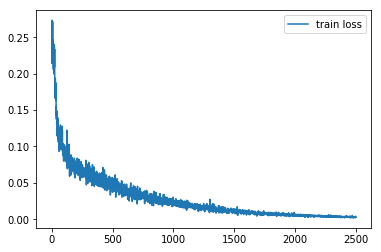

In [27]:
plot_loss(train_loss)

### Plotting test-set Embeddings of MNIST dataset

In [28]:
def test_model(model):
        model.eval()
        all_ = []
        all_labels = []
        #original_labels=[]
        for batch_idx, (x, labels) in enumerate(test_loader):
            x, labels = Variable(x, volatile=True), Variable(labels)
            output = model.forward_once(x)
            all_.extend(output.data.cpu().numpy().tolist())
            all_labels.extend(labels.data.cpu().numpy().tolist())

        numpy_all = np.array(all_)
        numpy_labels = np.array(all_labels)
        return numpy_all, numpy_labels

def testing_plots(model):
        dict_pickle={}
        numpy_all, numpy_labels = test_model(model)
        dict_pickle["numpy_all"]=numpy_all
        dict_pickle["numpy_labels"]=numpy_labels
        plot_mnist(numpy_all, numpy_labels)

/Users/sjadon/anaconda3/envs/mysite/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


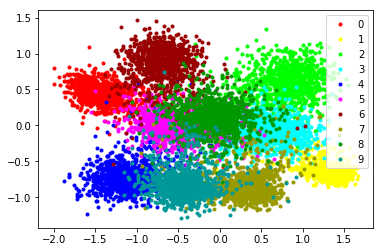

In [29]:
testing_plots(model)

#### In above embeddings Plot, what we can observe is that majority of points are in a cluster, whereas some points are not part of cluster, can be seen as outliers.